In [42]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
import pyproj

import pickle

# check pytorch version
import torch    
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

%load_ext autoreload
%autoreload 2
from functions import *
from torch_model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

ModuleNotFoundError: No module named 'torch_geometric_temporal'

In [44]:
data

Data(x=[102400, 8], edge_index=[2, 815364], y=[102400, 3])

In [82]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, 32, 1)
        self.linear1 = torch.nn.Linear(32, 32)
        self.linear2 = torch.nn.Linear(32, 3)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear1(h)
        h = self.linear2(h)
        return h, h_0, c_0

model = RecurrentGCN(8)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

RecurrentGCN(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_i): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_f): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_f): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_c): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_c): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_o): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_o): ChebConv(32, 32, K=1, normalization=sym)
  )
  (linear1): Linear(in_features=32, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)
Number of parameters: 6755


In [85]:
for epoch in range(10):
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(loader):
        y_hat, h, c = model(snapshot.x.to(torch.float), snapshot.edge_index, snapshot.edge_attr, h, c)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(epoch, cost)

0 tensor(0.0011, dtype=torch.float64, grad_fn=<DivBackward0>)
1 tensor(0.0012, dtype=torch.float64, grad_fn=<DivBackward0>)
2 tensor(0.0014, dtype=torch.float64, grad_fn=<DivBackward0>)
3 tensor(0.0016, dtype=torch.float64, grad_fn=<DivBackward0>)
4 tensor(0.0019, dtype=torch.float64, grad_fn=<DivBackward0>)
5 tensor(0.0022, dtype=torch.float64, grad_fn=<DivBackward0>)
6 tensor(0.0024, dtype=torch.float64, grad_fn=<DivBackward0>)
7 tensor(0.0025, dtype=torch.float64, grad_fn=<DivBackward0>)
8 tensor(0.0026, dtype=torch.float64, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [71]:
torch.ones(len(snapshot.x)).size()

torch.Size([307200])

In [74]:
snapshot.edge_index.size()[1]

2446092

In [86]:
print(model)
criterion = torch.nn.L1Loss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # Define optimizer.

def train(data):
    model.train()
    loss_all = 0
    h, c = None, None
    for data in loader:        
        optimizer.zero_grad()  # Clear gradients.
        out, h, c = model(data.x.to(torch.float), data.edge_index, data.edge_attr, h, c)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss


for epoch in range(100):
    model.train()
    loss_all = 0
    h, c = None, None
    for data in loader:        
        optimizer.zero_grad()  # Clear gradients.
        out, h, c = model(data.x.to(torch.float), data.edge_index, data.edge_attr, h, c)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

    if epoch % 10 == 0:
        print(epoch, loss)
        # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        # time.sleep(0.3)
print(epoch, loss)

RecurrentGCN(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_i): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_f): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_f): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_c): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_c): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_o): ChebConv(8, 32, K=1, normalization=sym)
    (conv_h_o): ChebConv(32, 32, K=1, normalization=sym)
  )
  (linear1): Linear(in_features=32, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)
0 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
10 tensor(0.0140, dtype=torch.float64, grad_fn=<MeanBackward0>)
20 tensor(0.0124, dtype=torch.float64, grad_fn=<MeanBackward0>)
30 tensor(0.0099, dtype=torch.float64, grad_fn=<MeanBackward0>)
40 tensor(0.0090, dtype=torch.float64, grad_fn=<MeanBackward0>)
50 tensor(0.0101, dtype=torch.float64, grad_fn=<MeanBack

In [99]:
data.edge_index

tensor([[     0,      0,      0,  ..., 307199, 307199, 307199],
        [   320,      1,    321,  ..., 306878, 306879, 307198]])

In [91]:
    
model.eval()
loss = 0
out, _, _ = model(snapshot.x.to(torch.float), snapshot.edge_index, snapshot.edge_attr, h, c)
loss += criterion(out, data.y)
# cost = cost / (time+1)
# cost = cost.item()
# print("MSE: {:.4f}".format(cost))

In [96]:
out[:, 0].detach().numpy()

array([0.0009702 , 0.00103188, 0.00109351, ..., 0.00285117, 0.00285152,
       0.0028519 ], dtype=float32)

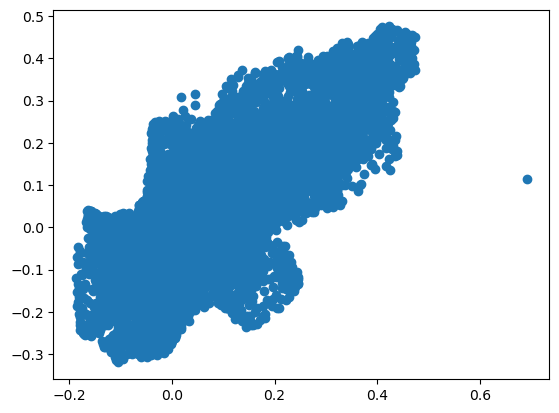

In [97]:
plt.scatter(out[:, 0].detach().numpy(), snapshot.y[:, 0].detach().numpy())

In [15]:
data_path = "D:\\PINN\\data"
with open(data_path + '/train_cnn_2019_2021.pkl', 'rb') as file:
    xx, yy, days, months, years, cnn_input, cnn_output = pickle.load(file)

xx = xx[41:, :-41]
yy = yy[41:, :-41]


cnn_input = np.transpose(cnn_input, (0, 3, 1, 2))[:, :, 41:, :-41].astype(np.double)
cnn_output = np.transpose(cnn_output, (0, 3, 1, 2))[:, :, 41:, :-41].astype(np.double)

n_samples, n_channels, row, col = np.shape(cnn_input)

xx_n = (xx - xx.min())/(xx.max() - xx.min())
yy_n = (yy - yy.min())/(yy.max() - yy.min())

# xx_n = np.expand_dims(np.expand_dims(xx_n, axis = 0), axis = 0)
# yy_n = np.expand_dims(np.expand_dims(yy_n, axis = 0), axis = 0)

# xx_n = np.repeat(xx_n, n_samples, axis=0)
# yy_n = np.repeat(yy_n, n_samples, axis=0)

# cnn_input = np.append(cnn_input, xx_n, axis = 1)
# cnn_input = np.append(cnn_input, yy_n, axis = 1)

# n_samples, n_channels, row, col = np.shape(cnn_input)


In [16]:
data_list = []

for i in tqdm(range(0, 3)):
    G = nx.grid_2d_graph(row,col)   
    G.add_edges_from([((x, y), (x+1, y+1)) for x in range(row-1) for y in range(col-1)] + [((x+1, y), (x, y+1)) for x in range(row-1) for y in range(col-1)])
    x = {node: torch.cat((torch.cat((torch.tensor([cnn_input[i][c][node] for c in range(0, n_channels)]), torch.tensor([xx_n[node]]))), torch.tensor([yy_n[node]])))
         for node in G.nodes()}
    y = {node: torch.tensor([cnn_output[i][c][node] for c in range(0, 3)]) for node in G.nodes()}
    nx.set_node_attributes(G, x, 'x')
    nx.set_node_attributes(G, y, 'y')
    
    data = from_networkx(G)
    filename = int(years[i]*10000 + months[i]*100 + days[i])
    # torch.save(data, f'../data/Graph/Grid_graph_{filename}.pt')
    data_list.append(data)
    
loader = DataLoader(data_list, batch_size=32)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:43<00:00, 34.35s/it]


In [46]:
filename = int(years[i]*10000 + months[i]*100 + days[i])
filename

20190105

In [47]:
filename = int(years[i]*10000 + months[i]*100 + days[i])
torch.save(data, f'../data/Graph/Grid_graph_{filename}.pt')

In [41]:
import torch
# im torch.nn
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels = 32):
        super().__init__()
        # torch.manual_seed(12345)
        self.lin1 = nn.Linear(8, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, 3)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x

# model = MLP(hidden_channels=16)
# print(model)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels = 16):
        super().__init__()
        # torch.manual_seed(1234567)
        self.conv1 = GCNConv(8, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2()
        x = x.relu() #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(8, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 3)
)


In [42]:
model = MLP()
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 11303


In [35]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = MyModel()
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 601


In [34]:
GCN.parameters()

TypeError: Module.parameters() missing 1 required positional argument: 'self'

In [31]:
total_params = sum(p.numel() for p in GCN.parameters())
print(f"Number of parameters: {total_params}")

TypeError: Module.parameters() missing 1 required positional argument: 'self'

In [9]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels = 32):
        super().__init__()
        # torch.manual_seed(1234)
        self.conv1 = GCNConv(8, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 3)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.leaky_relu(h, negative_slope=1)
        h = self.conv2(h, edge_index)
        h = F.leaky_relu(h, negative_slope=1)
        h = self.conv3(h, edge_index)
        # h = h.tanh()  # Final GNN embedding space.

        return h


In [10]:
model = GCN()
print(model)
criterion = torch.nn.L1Loss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    model.train()
    loss_all = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x.to(torch.float), data.edge_index)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(100):
    loss = train(data)
    if epoch % 10 == 0:
        print(epoch, loss)
        # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        # time.sleep(0.3)

GCN(
  (conv1): GCNConv(8, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 3)
)
0 tensor(0.2389, dtype=torch.float64, grad_fn=<MeanBackward0>)
10 tensor(0.0723, dtype=torch.float64, grad_fn=<MeanBackward0>)
20 tensor(0.0417, dtype=torch.float64, grad_fn=<MeanBackward0>)
30 tensor(0.0198, dtype=torch.float64, grad_fn=<MeanBackward0>)
40 tensor(0.0180, dtype=torch.float64, grad_fn=<MeanBackward0>)
50 tensor(0.0232, dtype=torch.float64, grad_fn=<MeanBackward0>)
60 tensor(0.0175, dtype=torch.float64, grad_fn=<MeanBackward0>)
70 tensor(0.0150, dtype=torch.float64, grad_fn=<MeanBackward0>)
80 tensor(0.0194, dtype=torch.float64, grad_fn=<MeanBackward0>)
90 tensor(0.0169, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [274]:
data

Data(x=[102400, 8], edge_index=[2, 408320], y=[102400, 3])

In [ ]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)


KeyboardInterrupt


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x0000019E2D42F1C0> (for post_execute):


In [138]:
G.nodes[(0,2)]

{'x': array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])}

ERROR! Session/line number was not unique in database. History logging moved to new session 183
